<a href="https://colab.research.google.com/github/maheshpec/dockie/blob/initial/notebooks/layoutlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [36]:
!pip install datasets pytesseract numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (8,927 kB/s)
Selecting previously unselect

In [9]:
from transformers import AutoModelForTokenClassification

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
model = AutoModelForTokenClassification.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")

In [12]:
from PIL import Image


Load an example from fundsd

In [13]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd-layoutlmv3 downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

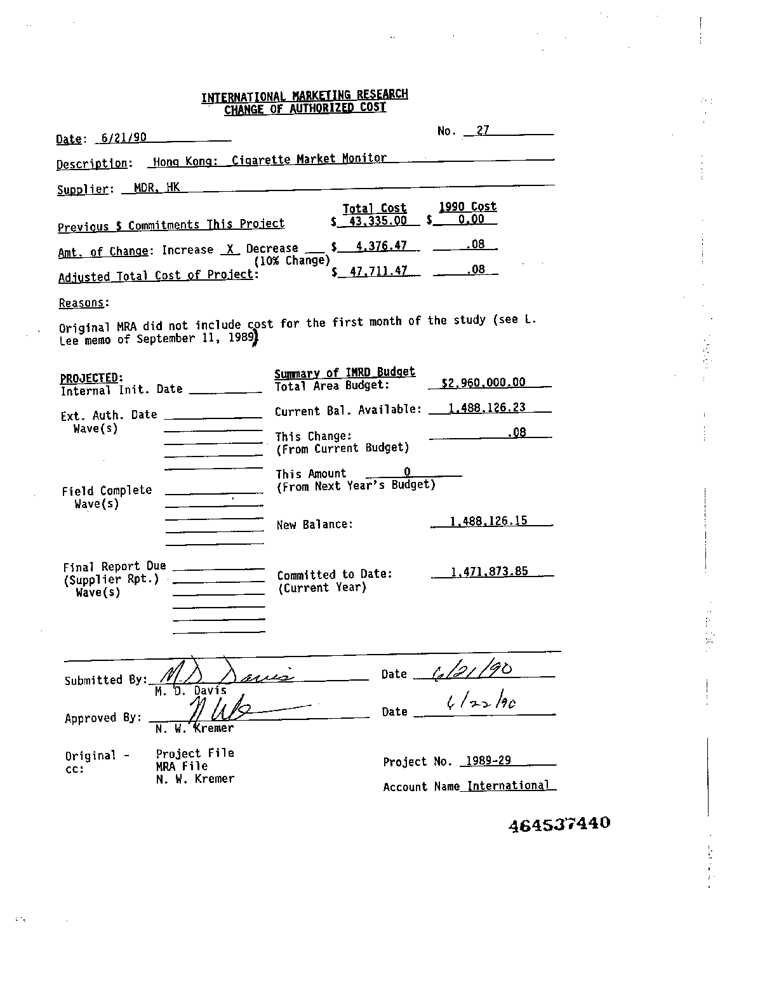

In [18]:
dataset["train"][20]["image"]

In [19]:
from transformers import AutoProcessor

# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [40]:
from datasets import Dataset
import pytesseract
import numpy as np

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        #image = Image.open(example['image_path'])
        image = example['image']

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

In [42]:
example = {}
example['image'] = dataset["train"][20]["image"]
example = apply_ocr(example)
print(example.keys())

dict_keys(['image', 'words', 'bbox'])
